# Project

- Project
- Project Description
- Libraries + Load Data
- Exploratory Analysis
- Data Reformation
- Text Vectorization
- Age Restriction
- CNN Embedding Extraction
- Train/Test data pipeline for NN + hyperparameters tunning
- Results

# Project Description

Search service. For the text description our service is suppose to find picture with the matching content. <br/>
<br/>
Extracting meaning out of text will happen with vectorization. <br/>
Convolutional NN will help us with extracting meaning out of pictures. <br/>
Finally we will build a NN which will predict weather two vectorized text is matched to the CNN embedding.

# Libraries + Load Data

In [22]:
import os
import random
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
spacy.load('en_core_web_sm')
import en_core_web_sm

from tqdm import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
np.random.seed(2023)
random.seed(2023)

In [3]:
# tensorflow

In [3]:
os.listdir('./datasets')

['test_images',
 'test_images.csv',
 '.DS_Store',
 'train_dataset.csv',
 'ExpertAnnotations.tsv',
 'CrowdAnnotations.tsv',
 'train_images',
 'test_queries.csv']

In [4]:
test_images = pd.read_csv('./datasets/test_images.csv')
test_images.sample(3)

,image
56,782401952_5bc5d3413a.jpg
12,2885891981_6b02620ae9.jpg
68,957682378_46c3b07bcd.jpg


In [5]:
train_dataset = pd.read_csv('./datasets/train_dataset.csv')
train_dataset.sample(3)

,image,query_id,query_text
1345,2421446839_fe7d46c177.jpg,533483374_86c5d4c13e.jpg#2,a dog on the beach .
2741,2913965136_2d00136697.jpg,2813033949_e19fa08805.jpg#2,A white and black dog is jumping in the air tr...
3914,2902269566_419d9f1d8e.jpg,2340206885_58754a799a.jpg#2,Three dogs in the snow .


In [6]:
ExpertAnnotations = pd.read_csv('./datasets/ExpertAnnotations.tsv', sep='\t', 
                                names=['file_name', 'query_id', 'score_1', 'score_2', 'score_3'])
ExpertAnnotations.sample(3)

,file_name,query_id,score_1,score_2,score_3
4690,3593392955_a4125087f6.jpg,2723477522_d89f5ac62b.jpg#2,3,3,3
161,1287073593_f3d2a62455.jpg,2708686056_1b8f356264.jpg#2,1,1,1
4999,3720366614_dfa8fe1088.jpg,2963573792_dd51b5fbfb.jpg#2,1,1,1


In [7]:
CrowdAnnotations = pd.read_csv('./datasets/CrowdAnnotations.tsv', sep='\t', 
                                names=['file_name', 'query_id', 'score_1', 'score_2', 'score_3'])
CrowdAnnotations.sample(3)

,file_name,query_id,score_1,score_2,score_3
27453,3214573346_d3a57f0328.jpg,3128164023_ebe8da4c32.jpg#2,0.000000,0,3
18079,2796801478_8ebd7e550b.jpg,2868575889_2c030aa8ae.jpg#2,0.333333,1,2
14017,2549968784_39bfbe44f9.jpg,539751252_2bd88c456b.jpg#2,0.333333,1,2


In [8]:
test_queries = pd.read_csv('./datasets/test_queries.csv', sep='|', index_col=0)
test_queries.sample(3)

,query_id,query_text,image
134,2517284816_9b8fd3c6b6.jpg#4,Middle school aged kids are showing their scho...,2517284816_9b8fd3c6b6.jpg
56,2060031241_a3ae7a06bb.jpg#1,a baby is holding a controller to a video game...,2060031241_a3ae7a06bb.jpg
299,3351418768_596ef7fd6f.jpg#4,A woman in purple with two children in the mou...,3351418768_596ef7fd6f.jpg


# Exploratory Analysis

Data Info:
- train_dataset - we will use this data to train convolutional network
- test_images - picture flow without description
- test_queries - prompts with unverified quality
- ExpertAnnotations - prompts quality rated by experts
- CrowdAnnotations - prompts quality rated by the volonteers

<div style="padding:1rem;background:aqua;">
    Let's check outliers and errors
</div>

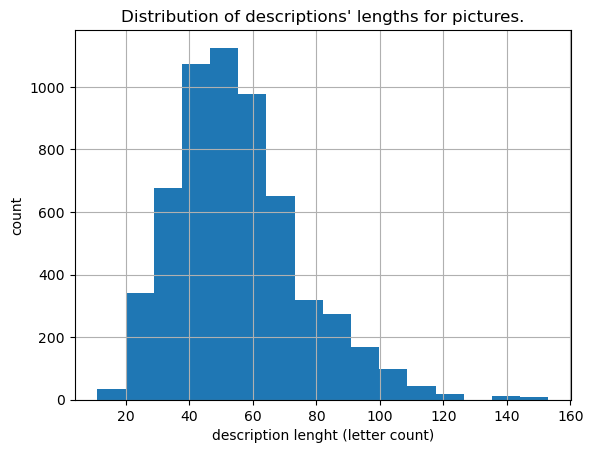

In [9]:
train_dataset.query_text.str.len().hist(bins=16)
plt.title('Distribution of descriptions\' lengths for pictures.')
plt.xlabel('description lenght (letter count)')
plt.ylabel('count')
plt.show()

Looks like a "normal" distribution

In [10]:
ExpertAnnotations.describe()

,score_1,score_2,score_3
count,5822.000000,5822.000000,5822.000000
mean,1.436620,1.624356,1.881999
std,0.787084,0.856222,0.904087
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


All score are in the right range 1-4

In [11]:
CrowdAnnotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  47830 non-null  object 
 1   query_id   47830 non-null  object 
 2   score_1    47830 non-null  float64
 3   score_2    47830 non-null  int64  
 4   score_3    47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


Data type is correct

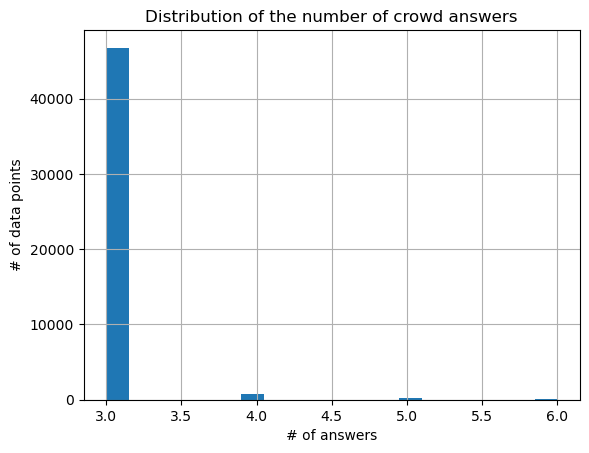

In [12]:
(CrowdAnnotations.score_2 + CrowdAnnotations.score_3).hist(bins=20)
plt.title('Distribution of the number of crowd answers')
plt.xlabel('# of answers')
plt.ylabel('# of data points')
plt.show()

The fact is the majority has only 3 crowd-source answers, the rest are not relevant.

# Data Reformation

Description of ExpertAnnotations: <br/>
1. File name
2. ID description <br/>
3-5 Score in range 1-4

Description CrowdAnnotations: <br/>
1. File name
2. ID description
3. Ratio of people who think description fits the picture
4. Count of people who think description fits the picture
5. Count of people who don't think description fits the picture

<div style="padding:1rem;background:aqua;">
    - Since our model will output a confidence ratio 0-1, we need a similar training data. <br/>
    - Experts score can be converted to one average and then apply tihs formula (x-1)/3. <br/>
    - The crowd-source ratio can be used in the exact manner, the importance will be 30% compared to experts.
</div>

In [13]:
prompt_score = ExpertAnnotations

In [14]:
prompt_score['score'] = prompt_score.score_1 + prompt_score.score_2 + prompt_score.score_3

In [15]:
# divide by 3 (3 summed scores), divide by 3 (ratio 0-1)
prompt_score.score = prompt_score.score.apply(lambda x: ((x/3) - 1)/3)

In [16]:
prompt_score = prompt_score.drop(columns=['score_1', 'score_2', 'score_3'])

In [17]:
prompt_score.sample(3)

,file_name,query_id,score
3592,3256043809_47258e0b3e.jpg,3585487286_ef9a8d4c56.jpg#2,0.333333
1964,2654514044_a70a6e2c21.jpg,2238019823_79318d1f11.jpg#2,0.000000
1039,224369028_b1ac40d1fa.jpg,2101457132_69c950bc45.jpg#2,0.000000


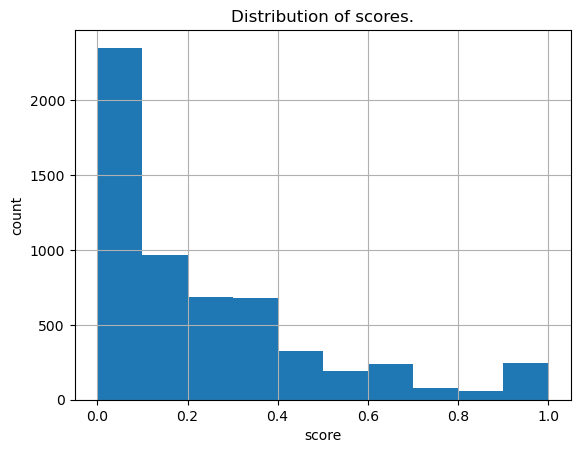

In [18]:
prompt_score.score.hist()
plt.title('Distribution of scores.')
plt.xlabel('score')
plt.ylabel('count')
plt.show()

In [19]:
step = pd.merge(prompt_score, CrowdAnnotations, how='left', on=['file_name','query_id'])

In [20]:
step.head()

,file_name,query_id,score,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.111111,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN,NaN,NaN


If there is crowd-source data, then will add it with importance 30%, else keep the old score.

In [23]:
def join_scores(row):
    if not math.isnan(row.score_1):
        return row.score * 0.7 + row.score_1 * 0.3
    return row.score

step.score = step.apply(lambda row: join_scores(row), axis=1)

In [24]:
step.head()

,file_name,query_id,score,score_1,score_2,score_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,0.000000,0.0,0.0,3.0
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.077778,0.0,0.0,3.0
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.111111,NaN,NaN,NaN
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.222222,NaN,NaN,NaN
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.111111,NaN,NaN,NaN


In [25]:
prompt_score = step.drop(columns=['score_1', 'score_2', 'score_3'])

# Text Vectorization

<div style="padding:1rem;background:aqua;">
    - We will vectorize text in the simple way. We lemmatize text, then extract BagOfWords and TF-IDF. <br/>
    - After we lemmatize text it will be easy to find age restricted content. <br/>
</div>

In [26]:
nlp = en_core_web_sm.load()

In [29]:
doc = nlp("I am hanging out in a green garden")
print([(token.lemma_, token.pos_) for token in doc])

[('I', 'PRON'), ('be', 'AUX'), ('hang', 'VERB'), ('out', 'ADP'), ('in', 'ADP'), ('a', 'DET'), ('green', 'ADJ'), ('garden', 'NOUN')]


In order to extract meaning we only need "V